# 机器学习之随机森林

#### 【简介】

随机森林是 Bagging 的一种扩展变体。该算法由于实现简单，抗噪声能力强，不容易发生过拟合现象，因此在很多业务中被广泛应用。

#### 【目录】

- [Bagging](#1.-Bagging)
- [随机森林算法流程](#2.-随机森林算法流程)
- [手写数字识别](#3.-手写数字识别)

## 1. Bagging

### 任务描述

补充python代码，完成`BaggingClassifier`类中的`fit`和`predict`函数

### 相关知识

为了完成本任务，需要掌握：

- 什么是Bagging
- Bagging算法如何训练与预测

#### 什么是Bagging

**Bagging**是**B**ootstrap **Agg**regat**ing**的英文缩写，初学者不要误认为Bagging是一种算法， **Bagging**和**Boosting**都是**集成学习**中的**学习框架**，代表着不同的思想。与Boosting这种串行集成学习算法不同， **Bagging**是**并行式集成学习**方法。大名鼎鼎的**随机森林算法**就是在Bagging的基础上修改的算法。

**Bagging**方法的**核心思想**就是**三个臭皮匠顶个诸葛亮**。如果使用Bagging解决**分类**问题，就是将**多个**分类器的结果**整合**起来进行**投票**，选取**票数最高**的结果作为**最终结果**。如果使用 Bagging解决**回归**问题，就将**多个**回归器的结果加起来然后求平均，将**平均值**作为**最终结果**。

那么Bagging方法为何有效呢？举个例子。狼人杀我相信大家都玩过，在天黑之前，村民们都要根据当天所发生的事和别人的发现来投票决定谁可能是狼人。

如果我们将每个村民看成是一个分类器，那么每个村民的任务就是二分类，假设$h_i(x)$表示第$i$个村民认为$x$是不是狼人($-1$代表不是狼人，$1$ 代表是狼人)，$f(x)$表示$x$真正的身份(是不是狼人)，$\epsilon$表示为村民判断错误的错误率。则有$P(h_i(x) \neq f(x)) = \epsilon$。

根据狼人杀的规则，村民们需要投票决定天黑前谁是狼人，也就是说如果有超过半数的村民投票时猜对了，那么这一轮就猜对了。那么假设现在有$T$个村民，$H(x)$表示投票后最终的结果，则有$H(x) = sign(\sum_{i=0}^T h_i(x))$

现在假设每个村民都是有主见的人，对于谁是狼人都有自己的想法，那么他们的错误率也是相互独立的。那么根据 Hoeffding不等式 可知，$H(x)$的错误率为：

$$
P(H(x) \neq f(x)) = \sum_{k=0}^{T/2}C_T^k(1 - \epsilon)^k \epsilon ^{T-k} \leq exp(-\frac{1}{2}T(1 - 2\epsilon)^2)
$$

根据上式可知，如果5个村民，每个村民的错误率为0.33，那么投票的错误率为0.749；如果20 个村民，每个村民的错误率为0.33，那么投票的错误率为0.315；如果50个村民，每个村民的错误率为0.33，那么投票的错误率为0.056；如果100个村民，每个村民的错误率为0.33，那么投票的错误率为0.003。从结果可以看出，村民的数量越大，那么投票后犯错的错误率就越小。这也是 Bagging 性能强的原因之一。

#### Bagging方法如何训练与预测

##### 训练

Bagging在训练时的特点就是**随机有放回采样**和**并行**。

- **随机有放回采样**：假设训练数据集有$m$条样本数据，每次从这$m$条数据中随机取一条数据放入采样集，然后将其返回，让下一次采样有机会仍然能被采样。然后重复$m$次，就能得到拥有$m$条数据的采样集，该采样集作Bagging的众多分类器中的一个作为训练数据集。假设有$T$个分类器（随便什么分类器），那么就重复$T$次随机有放回采样，构建出$T$个采样集分别作为$T$个分类器的训练数据集。

- **并行**：假设有10个分类器，在Boosting中，1号分类器训练完成之后才能开始2号分类器的训练，而在Bagging中，**分类器**可以**同时**进行**训练**，当所有分类器训练完成之后，整个Bagging的训练过程就结束了。

Bagging训练过程如下图所示：

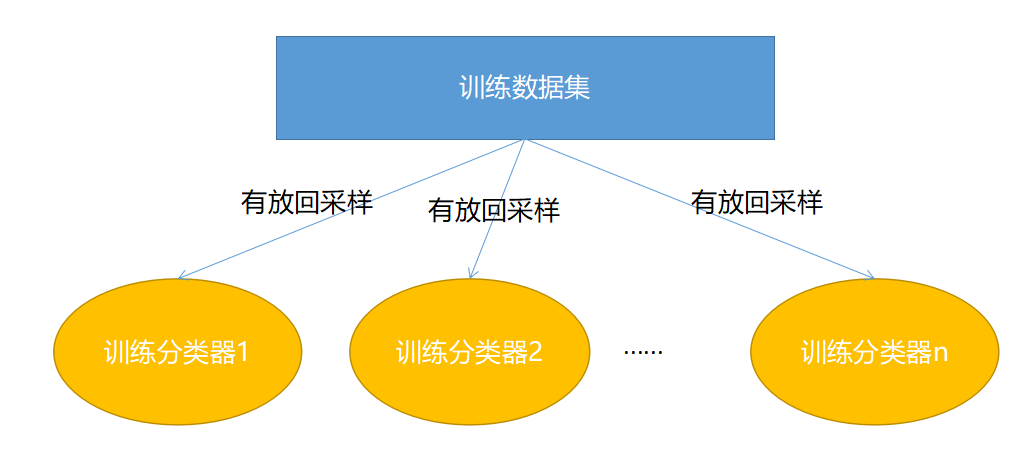

##### 预测

Bagging 在预测时非常简单，就是**投票**！比如现在有5个分类器，有3个分类器认为当前样本属于A类，1个分类器认为属于B类，1个分类器认为属于C类，那么Bagging的结果会是A类（因为 A类的票数最高）。

Bagging预测过程如下图所示:

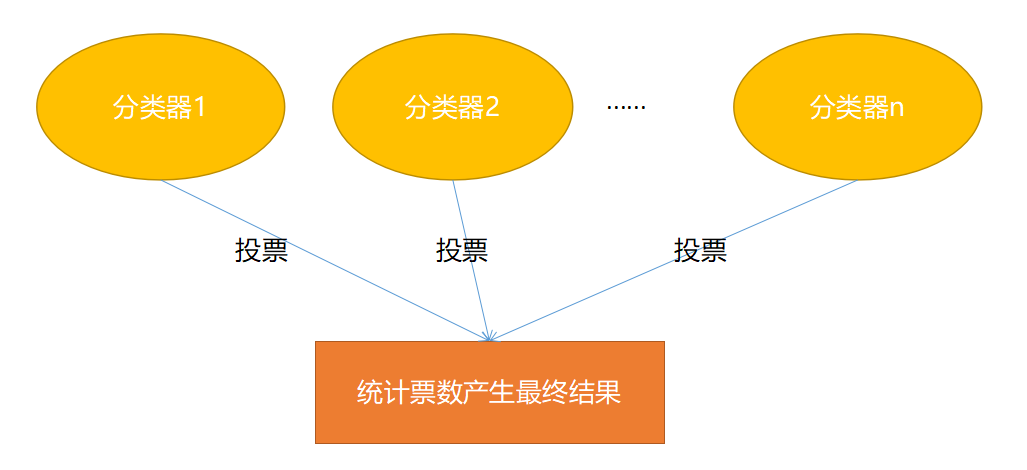

### 实操练习

#### 编程要求

在`begin-end`中完成`BaggingClassifier`类中的`fit`和`predict`函数。分类器可使用 `sklearn`提供的`DecisionTreeClassifier`。要求模型保存在`self.models`中。

`fit`函数用于`Bagging`的训练过程，其中：

- `feature` ：训练集数据，类型为 `ndarray`

- `label` ：训练集标签，类型为 `ndarray`

`predict`函数，实现预测功能，并将标签返回，其中：

- `feature` ：测试集数据，类型为`ndarray`

#### 测试说明

输出预测的准确率，应高于0.9

In [9]:
import numpy as np
from collections import Counter
from sklearn.tree import DecisionTreeClassifier

class BaggingClassifier():
    def __init__(self, n_model=10):
        '''
        初始化函数
        '''
        #分类器的数量，默认为10
        self.n_model = n_model
        #用于保存模型的列表，训练好分类器后将对象append进去即可
        self.models = []
        
    def fit(self, feature, label):
        '''
        训练模型，请记得将模型保存至self.models
        :param feature: 训练集数据，类型为ndarray
        :param label: 训练集标签，类型为ndarray
        :return: None
        '''
        #************* Begin ************#
        for i in range(self.n_model):
            m = len(feature)
            index = np.random.choice(m, m)
            sample_data = feature[index]
            sample_lable = label[index]
            model = DecisionTreeClassifier()
            model = model.fit(sample_data, sample_lable)
            self.models.append(model)
        #************* End **************#
        
    def predict(self, feature):
        '''
        :param feature: 测试集数据，类型为ndarray
        :return: 预测结果，类型为ndarray
        '''
        #************* Begin ************#
        result = []
        vote = []
        for model in self.models:
            r = model.predict(feature)
            vote.append(r)
        vote = np.array(vote)
        for i in range(len(feature)):
            v = sorted(Counter(vote[:, i]).items(), key=lambda x: x[1], reverse=True)
            result.append(v[0][0])
        return np.array(result)
        #************* End **************#

In [10]:
from sklearn import datasets
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
import numpy as np
# 加载iris数据集
iris = datasets.load_iris()
X = iris.data
y = iris.target
# 拆分数据集
X_train, X_test, y_train, y_test = train_test_split(
    X, y, 
    test_size=0.2, random_state=11
)
# 创建Bagging分类器
bc = BaggingClassifier()
# 训练（拟合）
bc.fit(X_train, y_train)
# 预测
y_pred = bc.predict(X_test)
# 评估
acc = accuracy_score(y_test, y_pred)
acc

0.9333333333333333

## 2. 随机森林算法流程

### 任务描述

补充 python 代码，完成`RandomForestClassifier`类中的`fit`和`predict`函数。

### 相关知识

为了完成本任务，需要掌握随机森林的训练与预测流程。

#### 随机森林的训练流程

**随机森林**是**Bagging**的一种**扩展变体**，随机森林的训练过程相对与Bagging的训练过程的改变有：

- **基学习器**：Bagging的基学习器可以是任意学习器，而**随机森林**则是以**决策树**作为**基学习器**。
- **随机属性选择**：假设原始训练数据集有10个特征，从这10个特征中**随机选取k个特征**构成训练数据子集，然后将这个子集作为训练集扔给决策树去训练。其中**k的取值**一般为**$log_2(特征数量)$** 。

这样的改动通常会使得**随机森林**具有**更强的泛化能力**，因为每一棵决策树的训练数据集是随机的，而且训练数据集中的特征也是随机抽取的。如果每一棵决策树模型的差异比较大，那么就很容易能够解决决策树容易过拟合的问题。

随机森林训练过程伪代码如下：

#### 随机森林的预测流程

随机森林的预测流程与Bagging的预测流程基本一致，如果是**回归**，就将结果基学习器的**预测结果**全部加起来算**平均**；如果是**分类**，就**投票**，**票数最多**的结果作为**最终结果**。但需要注意的是，在**预测时所用到的特征**必须与**训练模型时所用到的特征保持一致**。例如，第3棵决策树在训练时用到了训练集的第2，5，8这3 个特征。那么在预测时也要用第2，5，8 这3个特征所组成的测试集传给第3棵决策树进行预测。

### 实操练习

#### 编程要求

在`begin-end`中完成`RandomForestClassifier`类中的`fit`和`predict`函数。分类器可使用`sklearn`提供的`DecisionTreeClassifier`，要求模型保存在`self.models`中。

`fit`函数用于随机森林的训练过程，其中：

- `feature` ：训练集数据，类型为`ndarray` 
- `label`：训练集标签，类型为`ndarray` 

`predict`函数，实现预测功能，并将标签返回，其中：

- `feature` ：测试集数据，类型为`ndarray`

#### 测试说明

输出预测的准确率，应高于0.9

In [14]:
import numpy as np
from collections import  Counter
from sklearn.tree import DecisionTreeClassifier

class RandomForestClassifier():
    def __init__(self, n_model=10):
        '''
        初始化函数
        '''
        #分类器的数量，默认为10
        self.n_model = n_model
        #用于保存模型的列表，训练好分类器后将对象append进去即可
        self.models = []
        #用于保存决策树训练时随机选取的列的索引
        self.col_indexs = []
        
    def fit(self, feature, label):
        '''
        训练模型
        :param feature: 训练集数据，类型为ndarray
        :param label: 训练集标签，类型为ndarray
        :return: None
        '''
        #************* Begin ************#
        for i in range(self.n_model):
            m = len(feature)
            index = np.random.choice(m, m)
            col_index = np.random.permutation(len(feature[0]))[:int(np.log2(len(feature[0])))]
            sample_data = feature[index]
            sample_data = sample_data[:, col_index]
            sample_lable = label[index]
            model = DecisionTreeClassifier()
            model = model.fit(sample_data, sample_lable)
            self.models.append(model)
            self.col_indexs.append(col_index)
        #************* End **************#
        
    def predict(self, feature):
        '''
        :param feature: 测试集数据，类型为ndarray
        :return:预测结果，类型为ndarray，如np.array([0, 1, 2, 2, 1, 0])
        '''
        #************* Begin ************#
        result = []
        vote = []
        for i, model in enumerate(self.models):
            f = feature[:, self.col_indexs[i]]
            r = model.predict(f)
            vote.append(r)
        vote = np.array(vote)
        for i in range(len(feature)):
            v = sorted(Counter(vote[:, i]).items(), key=lambda x: x[1], reverse=True)
            result.append(v[0][0])
        return np.array(result)
        #************* End **************#

In [15]:
from sklearn import datasets
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
import numpy as np

# 使用前面的iris数据集进行训练与测试随机森林分类器
# 创建随机森林分类器
rfc = RandomForestClassifier()
# 拟合（训练）
rfc.fit(X_train, y_train)
# 预测
y_pred = rfc.predict(X_test)
# 评估
acc = accuracy_score(y_test, y_pred)
acc

0.9649122807017544

In [16]:
# 使用乳腺癌数据集训练与测试随机森林分类器
cancer = datasets.load_breast_cancer()
X = cancer.data
y = cancer.target
# 拆分数据集
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.1, random_state=1
)
# 创建随机森林分类器
rfc = RandomForestClassifier()
# 拟合（训练）
rfc.fit(X_train, y_train)
# 预测
y_pred = rfc.predict(X_test)
# 评估
acc = accuracy_score(y_test, y_pred)
acc

0.9298245614035088

## 3. 手写数字识别

### 任务描述

使用sklearn中的RandomForestClassifie 类完成手写数字识别任务

### 相关知识

为了完成本任务，需要掌握如何使用`sklearn`提供的`RandomForestClassifier`类。

#### 数据集简介

本任务使用的是**手写数字数据集**，该数据集有1797个样本，每个样本包括`8*8像素`（实际上是一条样本有64 个特征，每个**像素**看成是一个**特征**，每个特征都是`float`类型的数值）的图像和一个`[0, 9]`整数的标签。比如下图的标签是2：

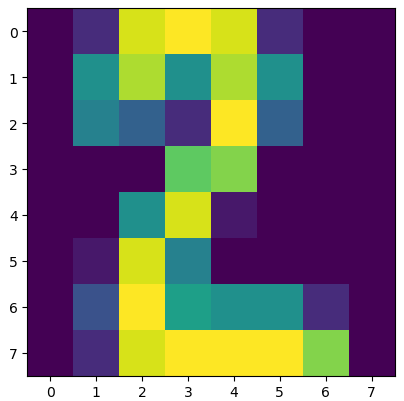

#### RandomForestClassifier 

`RandomForestClassifier`的构造函数中有两个常用的参数可以设置：

- `n_estimators`：森林中决策树的数量
- `criterion`：构建决策树时，划分节点时用到的指标。有`gini`（基尼系数）,`entropy`(信息增益)。若不设置，默认为`gini`
- `max_depth`：决策树的最大深度，如果发现模型已经出现过拟合，可以尝试将该参数调小。若不设置，默认为 None
- `max_features`：随机选取特征时选取特征的数量，一般传入`auto`或者`log2`，默认为`auto`，`auto`表示max_features=$\sqrt{训练集中特征的数量}$，`log2`表示max_features=$log_2(训练集中特征的数量)$ 

`RandomForestClassifier`类中的`fit`函数实现了随机森林分类器训练模型的功能，`predict`函数实现了模型预测的功能

其中 `fit`函数的参数如下：

- `X`：大小为`(样本数量,特征数量)`的`ndarry`，存放训练样本
- `Y`：值为整型，大小为(样本数量)的 `ndarray`，存放训练样本的分类标签

而 predict 函数有一个向量输入：

- `X` ：大小为`(样本数量,特征数量)`的`ndarry`，存放预测样本

### 实操练习

#### 编程要求

在`begin-end`之间填写`digit_predict(train_images, train_labels, test_images)`函数完成手写数字分类任务，其中：

- `train_images`：包含多条训练样本的样本集，类型为`ndarray`，`shape`为`[-1, 8, 8]`，在喂给分类器之前请记得将其变形
- `train_labels`：包含多条训练样本标签的标签集，类型为`ndarray`
- `test_images`：包含多条测试样本的测试集，类型为`ndarray`
- `return` ：`test_images`对应的预测标签，类型为`ndarray`

#### 测试说明

输出预测正确率，应高于0.98

In [19]:
from sklearn.ensemble import RandomForestClassifier

def digit_predict(train_images, train_labels, test_images):
    '''
    实现功能：训练模型并输出预测结果
    :param train_images: 包含多条训练样本的样本集，类型为ndarray,shape为[-1, 8, 8]
    :param train_labels: 包含多条训练样本标签的标签集，类型为ndarray
    :param test_images: 包含多条测试样本的测试集，类型为ndarry
    :return: test_images对应的预测标签，类型为ndarray
    '''
    #************* Begin ************#
    # 训练集变形
    flat_train_images = train_images.reshape((-1, 64))
    # 测试集变形
    flat_test_images = test_images.reshape((-1, 64))
    rf = RandomForestClassifier(20, max_depth=14)
    rf.fit(flat_train_images, train_labels)
    return rf.predict(flat_test_images)
    #************* End **************#

In [27]:
from sklearn import datasets
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
import numpy as np

# 加载手写数字数据集
digits = datasets.load_digits()
X = digits.data
y = digits.target
# 拆分数据集
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=112
)
# 训练并预测
y_pred = digit_predict(X_train, y_train, X_test)
# 评估模型
acc = accuracy_score(y_test, y_pred)
acc

0.9833333333333333

In [28]:
help(digit_predict)

Help on function digit_predict in module __main__:

digit_predict(train_images, train_labels, test_images)
    实现功能：训练模型并输出预测结果
    :param train_images: 包含多条训练样本的样本集，类型为ndarray,shape为[-1, 8, 8]
    :param train_labels: 包含多条训练样本标签的标签集，类型为ndarray
    :param test_images: 包含多条测试样本的测试集，类型为ndarry
    :return: test_images对应的预测标签，类型为ndarray

